In [28]:
import numpy as np
from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torch.utils.data
from tqdm import tqdm

torch.Size([1, 28, 28]) 6


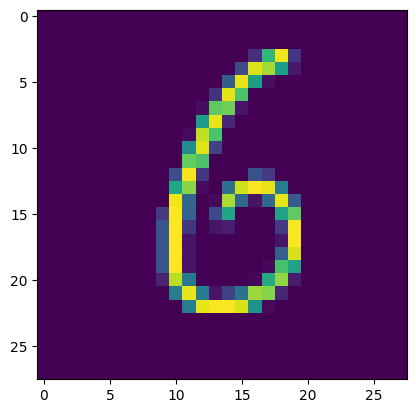

In [30]:
trainingdata = torchvision.datasets.MNIST("/media/volume/sdb/data",train=True, transform=torchvision.transforms.ToTensor(), download=True)
testdata = torchvision.datasets.MNIST("/media/volume/sdb/data",train=False, transform=torchvision.transforms.ToTensor(), download=True)

image, label = trainingdata[18]
print(image.shape, label)

plt.imshow(image.squeeze().numpy())
plt.show()

traindataloader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testdataloader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)

In [31]:
# Define our training loop
def train_loop(data_loader, ae, opt, device):
    ae.train()
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, ae, device):
    ae.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [32]:
# start off by defining multiple modules that encompass our autoencoder

# The encoder will take the ground truth sample as input and project it down into some smaller latent representation.
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.c1 = nn.Conv2d(1, 5, 4, 2, 1)
        self.c2 = nn.Conv2d(5, 10, 4, 2, 1)
        self.l1 = nn.Linear(490, 256)
        
    def forward(self, x):
        x = self.c2(F.relu(self.c1(x)))
        x = x.flatten(1)
        x = self.l1(F.relu(x))
        return x
    
# The decoder will take the encoded latent representation as input and predict what the original input to the encoder block was
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.cT2 = nn.ConvTranspose2d(10, 5, 2, 2)
        self.cT1 = nn.ConvTranspose2d(5, 1, 2, 2)
        self.l1 = nn.Linear(256, 490)
        
    def forward(self, x):
        x = torch.sin(self.l1(x))
        x = rearrange(x, 'b (c h w) -> b c h w', c=10, h=7, w=7)
        x = self.cT1(F.relu(self.cT2(x)))
        return x
    
    
# For ease of use we package the encoder and decoder into a single module
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        latents = self.encoder(x)
        recon = self.decoder(latents)
        return recon, latents

In [33]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Init all of our models
ae = AE()
ae.to(device)
print("Number of parameters: ", sum(p.numel() for p in ae.parameters()))

opt = torch.optim.Adam(ae.parameters(), lr=3e-4)

for i in tqdm(range(5)):
    loss_rec = train_loop(traindataloader, ae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(testdataloader, ae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  252747


  0%|          | 0/5 [00:00<?, ?it/s]

loss from epoch  0 :  0.10284942837714005


 20%|██        | 1/5 [00:07<00:31,  7.84s/it]

test loss:  0.03234785155743171
loss from epoch  1 :  0.022290652591997244


 40%|████      | 2/5 [00:15<00:23,  7.81s/it]

test loss:  0.017015164320588493
loss from epoch  2 :  0.014861761697573956


 60%|██████    | 3/5 [00:23<00:15,  7.80s/it]

test loss:  0.012716629299198746
loss from epoch  3 :  0.011535518939720034


 80%|████████  | 4/5 [00:31<00:07,  7.73s/it]

test loss:  0.010095031973520283
loss from epoch  4 :  0.008798595116253315


100%|██████████| 5/5 [00:38<00:00,  7.75s/it]

test loss:  0.007493459100532494


As we saw in the 'DeepLearning' notebook the latent space of the autoencoder is roughly grouped/clustered according to class. With that in mind, what happens if we traverse the latent space. That is, what if we start from the 5's cluster and slowly work our way to the 6's cluster? How will the decoder react to the space between each cluster?

What do we need to do to satisfy this question?
* randomly sample one 5 and one 6.
* pass each sample through the encoder to get their respective latent codes.
* write a function to linearly interpolate between the two latent codes.
* pass each latent code generated from the linearly interpolation function to the decoder.
* plot each decoded latent code. 

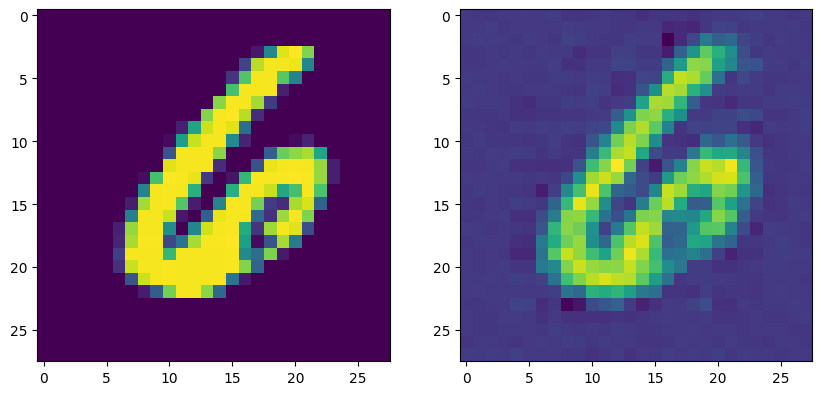

In [34]:
ae.eval()
image, label = trainingdata[737]
pred, latent_6 = ae(image.to(device).unsqueeze(0))
# Init figure w/ subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image.squeeze().numpy())
ax2.imshow(pred.detach().cpu().squeeze().squeeze().numpy())

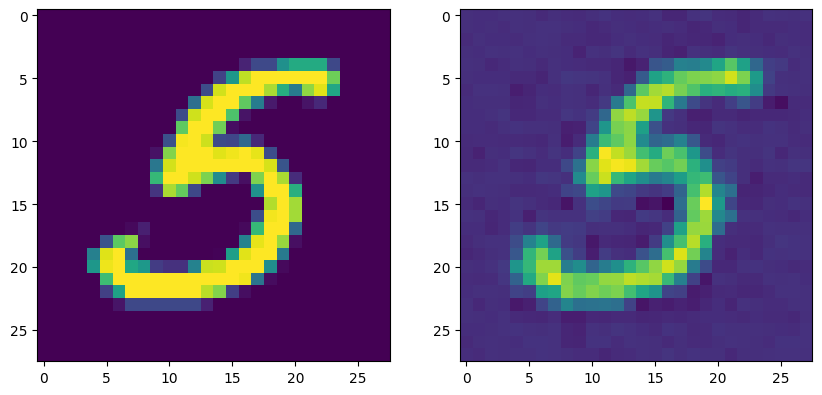

In [35]:
ae.eval()
image, label = trainingdata[837]
pred, latent_5 = ae(image.to(device).unsqueeze(0))
# Init figure w/ subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image.squeeze().numpy())
ax2.imshow(pred.detach().cpu().squeeze().squeeze().numpy())

In [36]:
def interpolate(start_tensor, end_tensor, num_steps):
    """
    Linearly interpolate between two tensors.

    Args:
        start_tensor (torch.Tensor): The starting tensor.
        end_tensor (torch.Tensor): The ending tensor.
        num_steps (int): The number of interpolation steps to take.

    Returns:
        A list of tensors, each representing an interpolated value between
        the start and end tensors.
    """
    # Determine the step size between the start and end tensors.
    step = (end_tensor - start_tensor) / (num_steps - 1)

    # Perform linear interpolation between the start and end tensors.
    interpolated_tensors = [start_tensor + i * step for i in range(num_steps)]

    return interpolated_tensors

In [37]:
interpolations = interpolate(latent_5, latent_6, 10)
inters = rearrange(interpolations, 'b c l -> b c l')
print(len(interpolations))
print(inters.shape)

10
torch.Size([10, 1, 256])


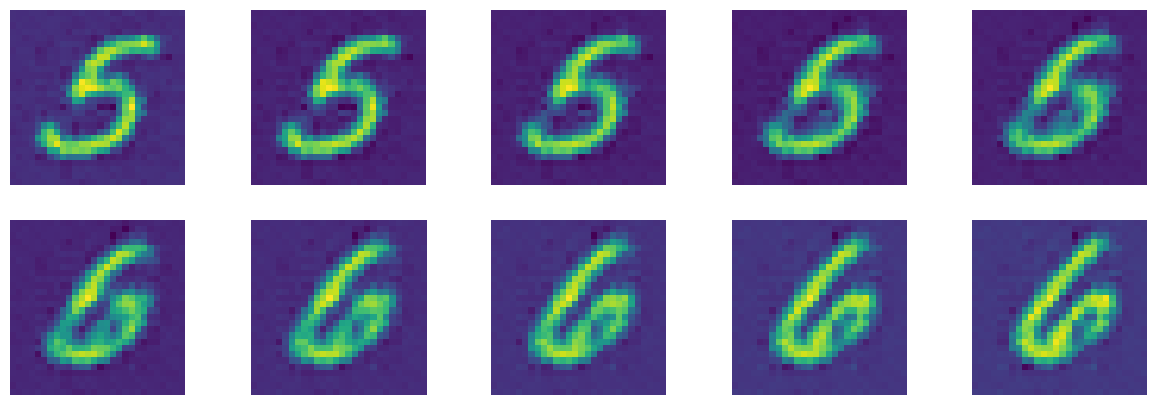

In [38]:
with torch.no_grad():
    inters_decoded = ae.decoder(inters.squeeze())
    
# move tensor to cpu and conver to numpy array
inters_decoded = inters_decoded.cpu().numpy().squeeze()


# Plot the 100 images.
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(inters_decoded[i])
    axs[i].axis('off')
plt.show()

So, what does this mean? Well, one fair assumption we can make is there is potentially a slight overlap between the latent cluster of 5's and the latent cluster of 6's which can be seen in the 5th image. 
A next question might be; what happens if there isn't an overlap in latent clusters?
To answer this we can carry out the same process, but for each different class in the dataset. Let's continue to use 5 as our starting point and interpolate between each class in the dataset. 

In [39]:
# get latents for each class
ae.eval()
# 0
image_0, label = trainingdata[1]
pred_0, latent_0 = ae(image_0.to(device).unsqueeze(0))
# 1
image_1, label = trainingdata[3]
pred_1, latent_1 = ae(image_1.to(device).unsqueeze(0))
# 2
image_2, label = trainingdata[5]
pred_2, latent_2 = ae(image_2.to(device).unsqueeze(0))
# 3
image_3, label = trainingdata[7]
pred_3, latent_3 = ae(image_3.to(device).unsqueeze(0))
# 4
image_4, label = trainingdata[2]
pred_4, latent_4 = ae(image_4.to(device).unsqueeze(0))
# 5
image_5, label = trainingdata[837]
pred_5, latent_5 = ae(image_5.to(device).unsqueeze(0))
# 6
image_6, label = trainingdata[737]
pred_6, latent_6 = ae(image_6.to(device).unsqueeze(0))
# 7
image_7, label = trainingdata[15]
pred_7, latent_7 = ae(image_7.to(device).unsqueeze(0))
# 8
image_8, label = trainingdata[17]
pred_8, latent_8 = ae(image_8.to(device).unsqueeze(0))
# 9
image_9, label = trainingdata[4]
pred_9, latent_9 = ae(image_9.to(device).unsqueeze(0))

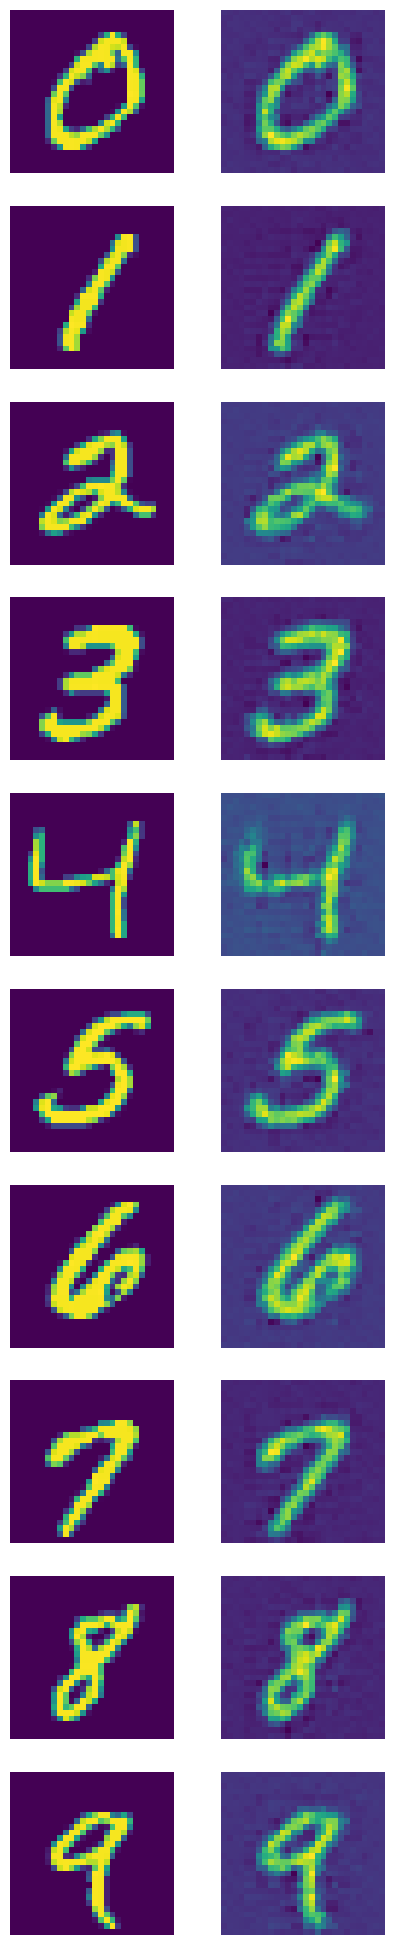

In [40]:
# Put all the latent vectors and predicted images in lists.
images = [image_0, image_1, image_2, image_3, image_4, image_5, image_6, image_7, image_8, image_9]
preds = [pred_0, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, pred_7, pred_8, pred_9]

# Create a figure with 10 subplots, each row showing one original image and one predicted image.
fig, axs = plt.subplots(10, 2, figsize=(5, 25))

# Iterate over the 10 classes and plot the corresponding images and predicted images side by side.
for i in range(10):
    # Plot the original image on the left subplot.
    axs[i, 0].imshow(images[i].squeeze().numpy())
    axs[i, 0].axis('off')
    
    # Plot the predicted image on the right subplot.
    axs[i, 1].imshow(preds[i].detach().cpu().squeeze().squeeze().numpy())
    axs[i, 1].axis('off')
    
# Show the figure.
plt.show()


9
torch.Size([10, 1, 28, 28])


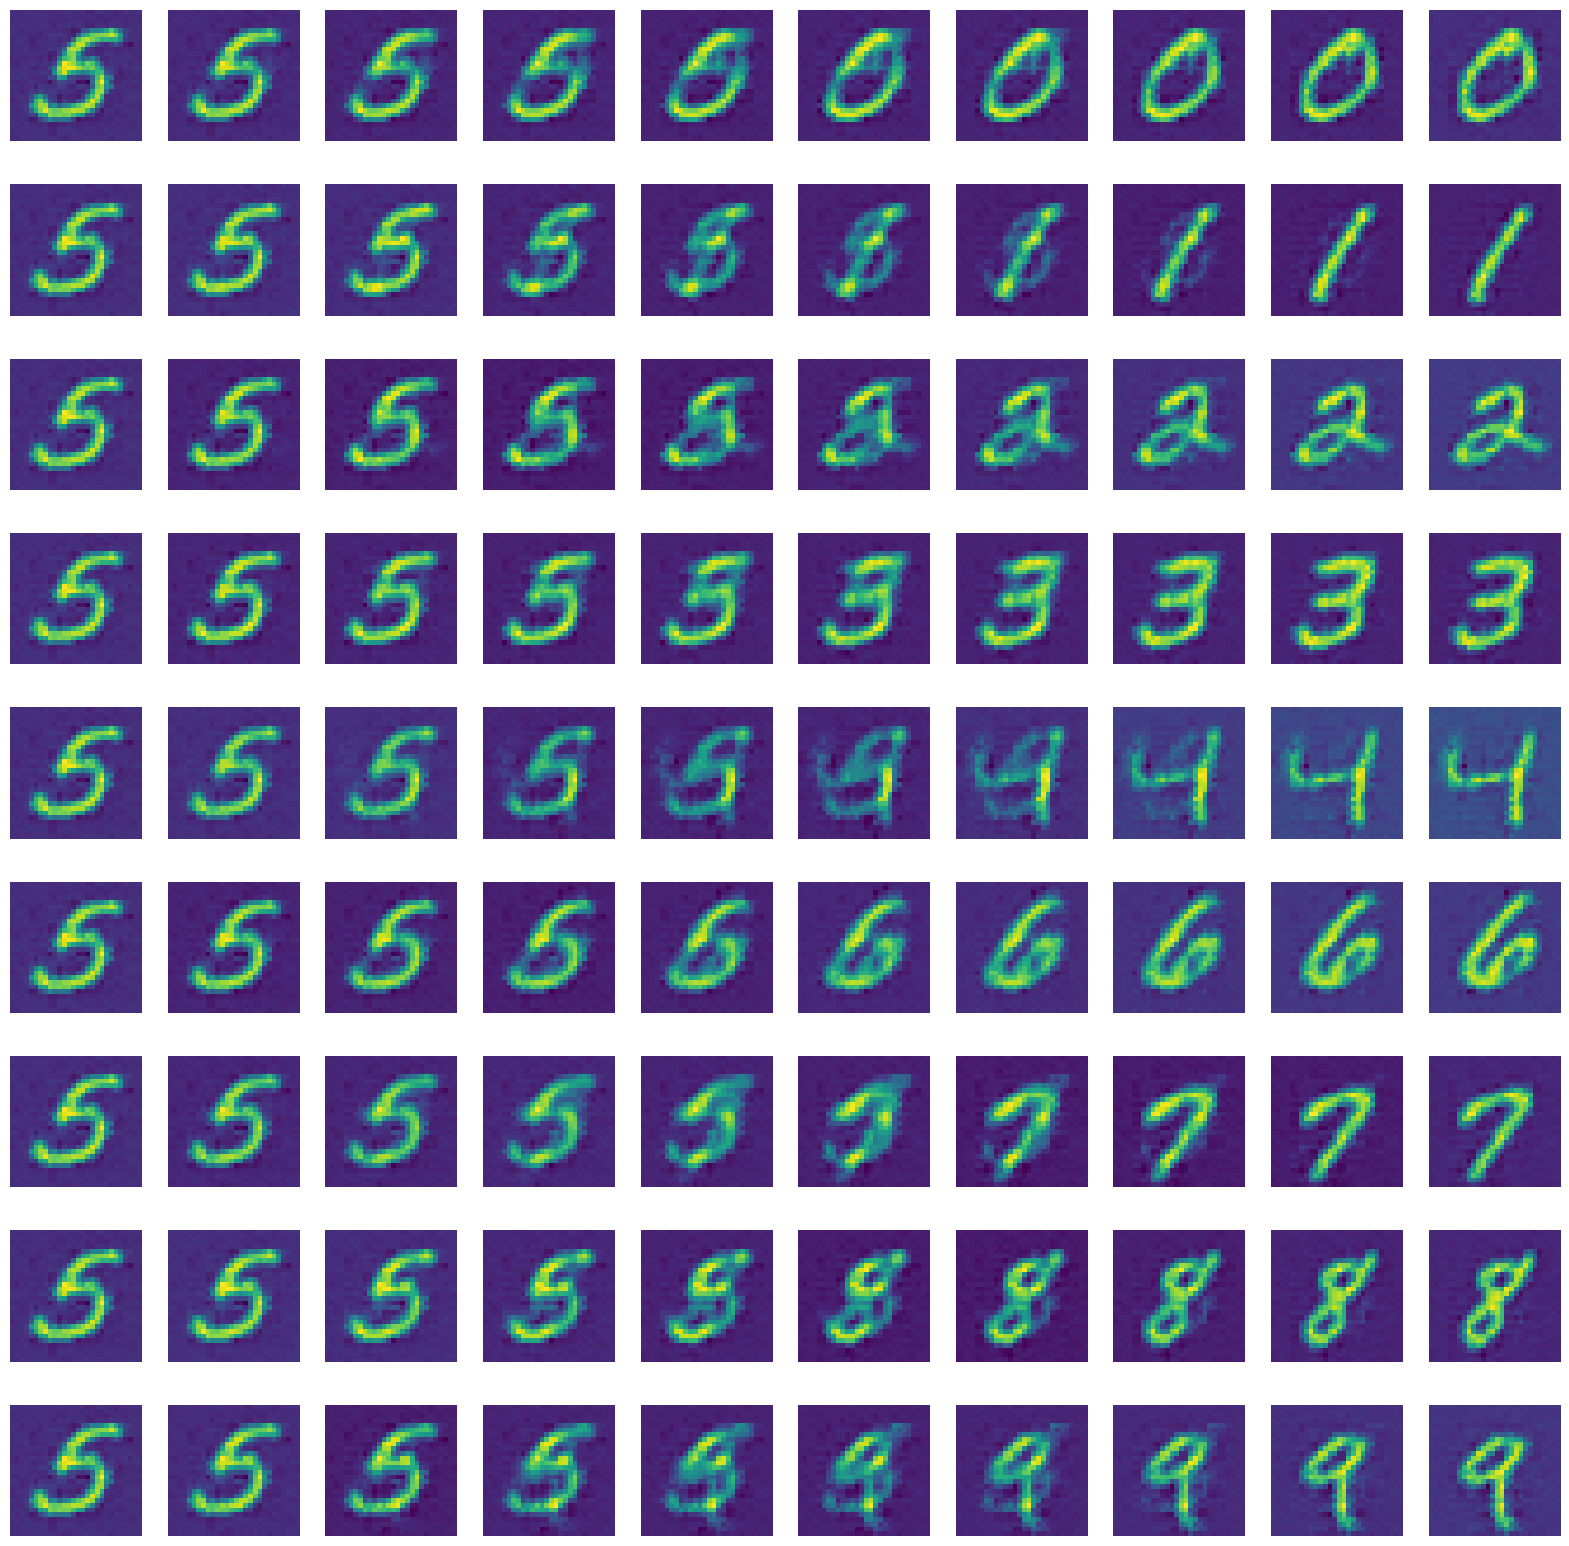

In [41]:
latents = [latent_0, latent_1, latent_2, latent_3, latent_4, latent_6, latent_7, latent_8, latent_9]
latents_interpolated = [interpolate(latent_5, latent, 10) for latent in latents]
recons_interpolated = []
with torch.no_grad():
    for i in range(len(latents_interpolated)):
        latents_batched = rearrange(latents_interpolated[i], 'b c l -> b c l')
        recons_batched = ae.decoder(latents_batched.squeeze())
        recons_interpolated.append(recons_batched)

print(len(recons_interpolated))
print(recons_interpolated[0].shape)

# # Plot the 90 images.
fig, axs = plt.subplots(9, 10, figsize=(20, 20))
for i in range(len(recons_interpolated)):
    for j in range(10):
        axs[i, j].imshow(recons_interpolated[i][j].cpu().numpy().squeeze())
        axs[i, j].axis('off')
plt.show()

Note when the latent "leaves" one cluster and enters another. 

In [42]:
from scipy import stats
stats.describe(latent_5.detach().flatten().cpu())

DescribeResult(nobs=256, minmax=(-2.1339278, 3.1486893), mean=-0.022157842, variance=0.7212167777267157, skewness=0.06438152878609996, kurtosis=0.094336179767744)

(array([ 8., 18., 42., 70., 47., 39., 26.,  5.,  0.,  1.]),
 array([-2.13392782, -1.60566616, -1.07740438, -0.54914272, -0.02088099,
         0.50738072,  1.03564239,  1.56390417,  2.09216595,  2.62042761,
         3.14868927]),
 <BarContainer object of 10 artists>)

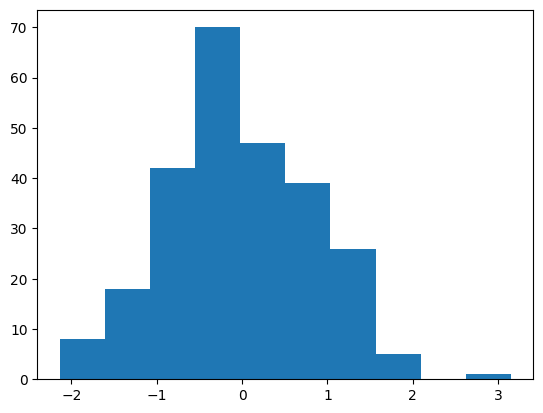

In [43]:
plt.hist(latent_5.detach().flatten().cpu().unsqueeze(0))